# **Define Some New Loss Functions**

In [39]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import losses



##########################################
############## ORDINAL LOSS ##############
##########################################

def ordinal_loss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * losses.categorical_crossentropy(y_true, y_pred)



##########################################
############### FOCAL LOSS ###############
##########################################

def categorical_focal_loss(gamma=2.0, alpha=0.25):
  """
  Implementation of Focal Loss from the paper in multiclass classification
  Formula:
      loss = -alpha*((1-p)^gamma)*log(p)
  Parameters:
      alpha -- the same as wighting factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
  Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
  """
  def focal_loss(y_true, y_pred):
      # Define epsilon so that the backpropagation will not result in NaN
      # for 0 divisor case
      epsilon = K.epsilon()
      # Add the epsilon to prediction value
      #y_pred = y_pred + epsilon
      # Clip the prediction value
      y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
      # Calculate cross entropy
      cross_entropy = -y_true*K.log(y_pred)
      # Calculate weight that consists of  modulating factor and weighting factor
      weight = alpha * y_true * K.pow((1-y_pred), gamma)
      # Calculate focal loss
      loss = weight * cross_entropy
      # Sum the losses in mini_batch
      loss = K.sum(loss, axis=1)
      return loss
  
  return focal_loss

def binary_focal_loss(gamma=2.0, alpha=0.25):
  """
  Implementation of Focal Loss from the paper in multiclass classification
  Formula:
      loss = -alpha_t*((1-p_t)^gamma)*log(p_t)
      
      p_t = y_pred, if y_true = 1
      p_t = 1-y_pred, otherwise
      
      alpha_t = alpha, if y_true=1
      alpha_t = 1-alpha, otherwise
      
      cross_entropy = -log(p_t)
  Parameters:
      alpha -- the same as wighting factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
  Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
  """
  def focal_loss(y_true, y_pred):
      # Define epsilon so that the backpropagation will not result in NaN
      # for 0 divisor case
      epsilon = K.epsilon()
      # Add the epsilon to prediction value
      #y_pred = y_pred + epsilon
      # Clip the prediciton value
      y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
      # Calculate p_t
      p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
      # Calculate alpha_t
      alpha_factor = K.ones_like(y_true)*alpha
      alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
      # Calculate cross entropy
      cross_entropy = -K.log(p_t)
      weight = alpha_t * K.pow((1-p_t), gamma)
      # Calculate focal loss
      loss = weight * cross_entropy
      # Sum the losses in mini_batch
      loss = K.sum(loss, axis=1)
      return loss
  
  return focal_loss

# **Loading MNIST Dataset**

In [1]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

--2022-02-02 11:14:33--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2022-02-02 11:14:34 (97.5 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]



In [2]:
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

--2022-02-02 11:14:36--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0s      

2022-02-02 11:14:36 (312 MB/s) - ‘train-labels-idx1-ubyte.gz’ saved [28881/28881]



In [3]:
!gzip -d /content/train-images-idx3-ubyte.gz
!gzip -d /content/train-labels-idx1-ubyte.gz

In [4]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

In [5]:
convert("train-images-idx3-ubyte", "train-labels-idx1-ubyte",
        "mnist_train.csv", 60000)

In [6]:
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2022-02-02 11:15:03--  http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1648877 (1.6M) [application/x-gzip]
Saving to: ‘t10k-images-idx3-ubyte.gz’

t10k-images-idx3-ub 100%[===================>]   1.57M  --.-KB/s    in 0.06s   

2022-02-02 11:15:03 (26.8 MB/s) - ‘t10k-images-idx3-ubyte.gz’ saved [1648877/1648877]

--2022-02-02 11:15:03--  http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4542 (4.4K) [application/x-gzip]
Saving to: ‘t10k-labels-idx1-ubyte.gz’

t10k-labels-idx1-ub 100%[================

In [7]:
!gzip -d /content/t10k-images-idx3-ubyte.gz
!gzip -d /content/t10k-labels-idx1-ubyte.gz

In [8]:
convert("t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte",
        "mnist_test.csv", 10000)

# **Data Visualization**

In [9]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

In [10]:
train = genfromtxt('mnist_train.csv', delimiter=',')
test = genfromtxt('mnist_test.csv', delimiter=',')

In [11]:
train.shape, test.shape

((60000, 785), (10000, 785))

In [12]:
X_train = train[:, 1:].reshape((60000, 28, 28))
y_train = train[:,0]

X_test = test[:, 1:].reshape((10000, 28, 28))
y_test = test[:,0]

In [13]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [14]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

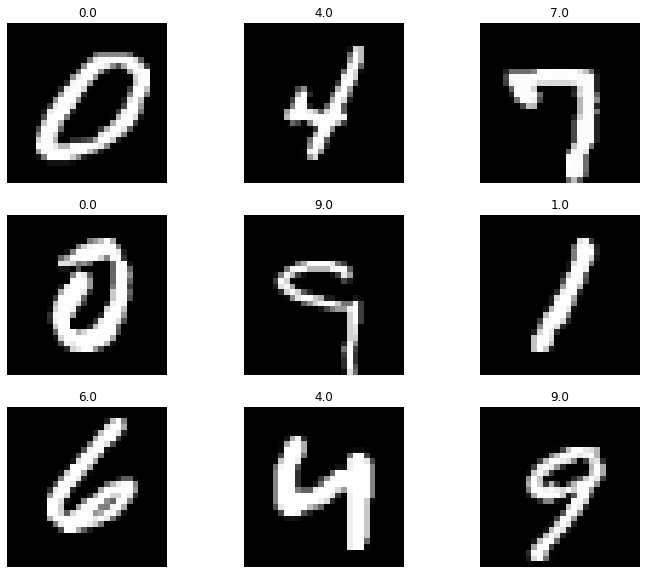

In [19]:
plt.figure(figsize=(12,10))

for i in range(1,10):

    n = np.random.randint(0,1000,1)[0]

    ax = plt.subplot(3,3,i)
    plt.axis('off')

    plt.imshow(X_train[n,:,:], cmap='gray')
    plt.title(y_train[n])


# **Preparing Data For Training**

In [20]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

X_train /= 255.
X_test /= 255.

In [21]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input

In [30]:
def cnn(loss='categorical_crossentropy', optimizer='adam', last_layer_activation='sigmoid'):

  model = Sequential()

  model.add(Input(shape=(28,28, 1)))

  model.add(Conv2D(filters=8, kernel_size=(3,3), input_shape=(28, 28, 1)))
  model.add(MaxPool2D((2,2)))

  model.add(Conv2D(16, kernel_size=(3,3), input_shape=(28, 28, 1)))
  model.add(MaxPool2D((2,2)))

  model.add(Flatten())

  model.add(Dense(32))
  model.add(Dense(10, activation=last_layer_activation))

  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [70]:
histories = []
loss = [('cat','categorical_crossentropy'), ('focal',categorical_focal_loss()), ('ordinal',ordinal_loss)]
optimizers = ['adam', 'SGD']
activations = ['softmax', 'sigmoid']
names = []

In [73]:
for act in activations:
  for opt in optimizers:
    for l_name,l in loss:

      model = cnn(l, opt, act)
      history = model.fit(X_train, y_train_cat, epochs=10, validation_data=(X_test, y_test_cat))
      histories.append(history)

      name = f"{l_name}_{opt}_{act}"
      names.append(name)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2168 - accuracy: 0.9358 - val_loss: 0.0797 - val_accuracy: 0.9752
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0806 - accuracy: 0.9754 - val_loss: 0.0696 - val_accuracy: 0.9770
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0655 - accuracy: 0.9804 - val_loss: 0.0722 - val_accuracy: 0.9780
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0575 - accuracy: 0.9825 - val_loss: 0.0571 - val_accuracy: 0.9810
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0521 - accuracy: 0.9839 - val_loss: 0.0516 - val_accuracy: 0.9835
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0474 - accuracy: 0.9854 - val_loss: 0.0537 - val_accuracy: 0.9827
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0534 - val_accura

Text(0.5, 1.0, 'val_accuracy')

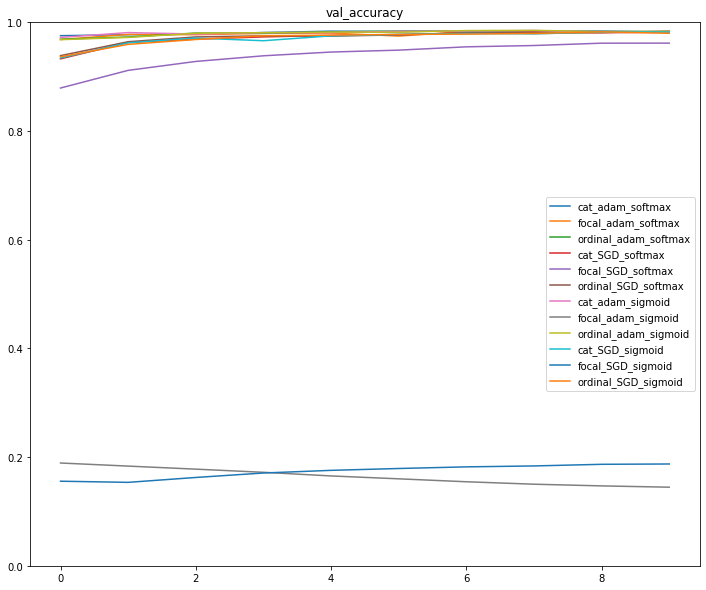

In [96]:
plt.figure(figsize=(12,10))
plt.ylim([0.0, 1.0])

for i,hist in enumerate(histories):
  plt.plot(hist.history['val_accuracy'], label=names[i])
plt.legend()
plt.title('val_accuracy')

Text(0.5, 1.0, 'val_accuracy')

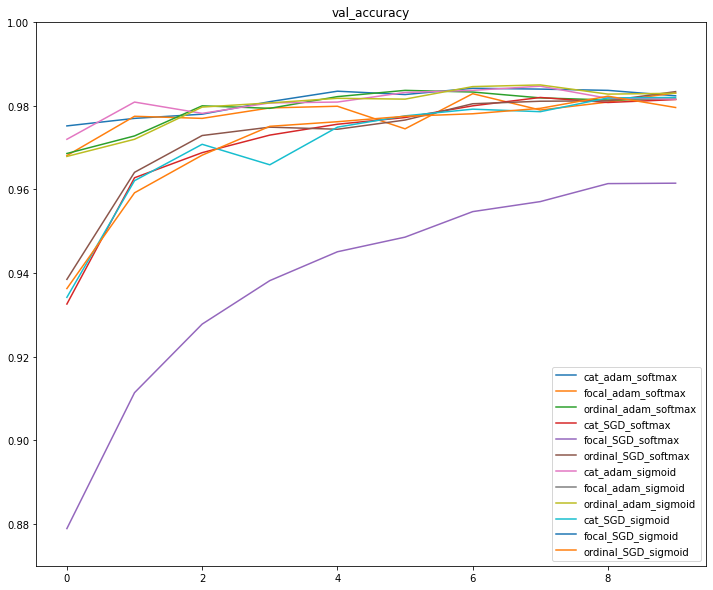

In [97]:
plt.figure(figsize=(12,10))
plt.ylim([0.87, 1.0])

for i,hist in enumerate(histories):
  plt.plot(hist.history['val_accuracy'], label=names[i])
plt.legend()
plt.title('val_accuracy')

Text(0.5, 1.0, 'val_loss')

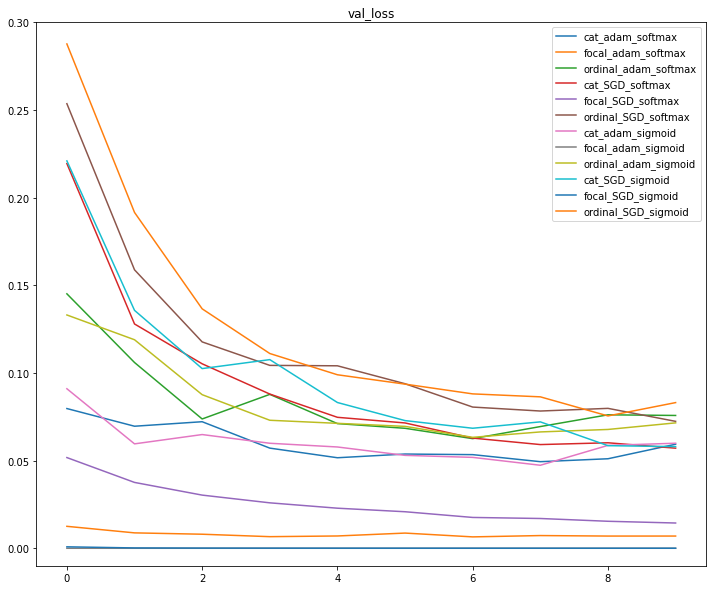

In [84]:
plt.figure(figsize=(12,10))
plt.ylim([-0.01, 0.3])

for i,hist in enumerate(histories):
  plt.plot(hist.history['val_loss'], label=names[i])
plt.legend()
plt.title('val_loss')

Text(0.5, 1.0, 'val_loss')

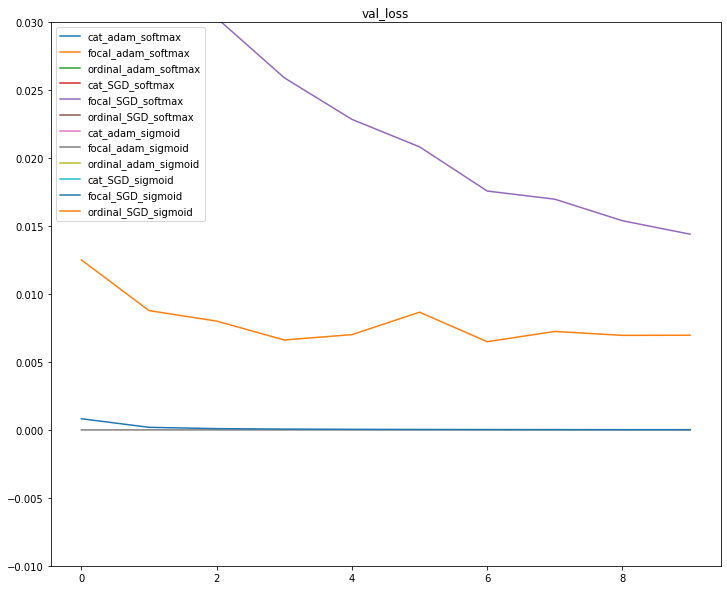

In [105]:
plt.figure(figsize=(12,10))
plt.ylim([-0.01, 0.03])

for i,hist in enumerate(histories):
  plt.plot(hist.history['val_loss'], label=names[i])
plt.legend()
plt.title('val_loss')

In [100]:
import pandas as pd


In [101]:
dd = {'model':[], 'val_accuracy':[], 'val_loss':[]}
for i,hist in enumerate(histories):
  dd['model'].append(names[i])
  dd['val_accuracy'].append(max(hist.history['val_accuracy']))
  dd['val_loss'].append(min(hist.history['val_loss']))

In [104]:
pd.DataFrame(dd)

,model,val_accuracy,val_loss
0,cat_adam_softmax,0.9842,4.937331e-02
1,focal_adam_softmax,0.9831,6.491292e-03
2,ordinal_adam_softmax,0.9837,6.251070e-02
3,cat_SGD_softmax,0.9820,5.708133e-02
4,focal_SGD_softmax,0.9615,1.440091e-02
5,ordinal_SGD_softmax,0.9834,7.237088e-02
6,cat_adam_sigmoid,0.9847,4.733746e-02
7,focal_adam_sigmoid,0.1891,1.719125e-11
8,ordinal_adam_sigmoid,0.9850,6.326357e-02
9,cat_SGD_sigmoid,0.9820,5.796525e-02
